# Large-scale bundle adjustment in scipy

TAGS: Optimization and fitting

AUTHORS: Nikolay Mayorov

A bundle adjusmtent problem arises in 3D reconstruction and it can be formulated as follows (taken from https://en.wikipedia.org/wiki/Bundle_adjustment):

> Given a set of images depicting a number of 3D points from different viewpoints, bundle adjustment can be defined as the problem of simultaneously refining the 3D coordinates describing the scene geometry as well as the parameters of the relative motion and the optical characteristics of the camera(s) employed to acquire the images, according to an optimality criterion involving the corresponding image projections of all points.

More specifically. 
We are given a set of points in real world defined by their coordinates $(X, Y, Z)$ in an apriori chosen world coordinate frame. 
These points are photographed by different cameras, which are characterized by their orientation and translation relative to the world coordinate frame and also by focal length and two radial distortion parameters (9 parameters in total). 
The corresponding 2D images coordinates $(x, y)$ of 3D points are measured.
The task is to refine 3D coordinates of the points as well as the camera parameters by minimizing the sum of squares of reprojecting errors, given an initial guess for all unknowns.

Let $\pmb{P} = (X, Y, Z)^T$ - a radius-vector of a point, $\pmb{R}$ - a rotation matrix of a camera, $\pmb{t}$ - a translation vector of a camera, $f$ - its focal length in pixels, $k_1, k_2$ - its radial distortion parameters. Then the transformation by a camera is defined as follows:

\begin{align}
\pmb{Q} = \pmb{R} \pmb{P} + \pmb{t} \\
\pmb{q} = -\begin{pmatrix} Q_x / Q_z \\ Q_y / Q_z \end{pmatrix} \\
\pmb{p} = f (1 + k_1 \lVert \pmb{q} \rVert^2 + k_2 \lVert \pmb{q} \rVert^4) \pmb{q}
\end{align}

The resulting vector $\pmb{p}=(x, y)^T$ contains image coordinates of the original point.
This model is called "pinhole camera model", you can read more about it here http://www.comp.nus.edu.sg/~cs4243/lecture/camera.pdf

Additional notes regarding the formulas above:
    
1. $\pmb{R}$ is the rotation matrix which projects from the world axes to the camera axes.
2. $\pmb{t}$ is the translation vector from the camera origin to the world origin expressed in the camera axes.
3. The minus sign for $\pmb{q}$ accounts for a particular camera axes convention: $x$ points right, $y$ points up and $z$ points backwards such that observed points have negative $z$ values. Usually $y$ and $z$ directions are chosen to be the opposite, but here we stick with the convention used in BAL dataset (see next).
4. The components of $\pmb{p}$ are pixel coordinates with $(0, 0)^T$ being the image center. Usually the pixel coordinates origin is chosen to be at the top left corner of an image and the image center parameters $c_x, c_y$ are considered or estimated. But here we stick with the convention used in BAL dataset where center parameters are not explicitly modeled.

Camera position $\pmb{t}'$ and rotation $\pmb{R}'$ relative to the world frame can be computed from $\pmb{R}, \pmb{t}$ as follows:

\begin{align}
\pmb{t}' = -\pmb{R}^T t \\
\pmb{R}' = \pmb{R}^T
\end{align}

The cost function to be minimized is the sum of squares of the reprojection errors: $F = \frac{1}{2} \sum_{i=1}^N \lVert \pmb{p}_i - \tilde{\pmb{p}}_i \rVert^2$. Where $N$ is the total number of 2D observations, $\pmb{p}_i$ is 2D coordinates of a point computed by the projection formulas from the estimated parameters, and $\pmb{\tilde{p}}_i$ is observed 2D coordinates.

--------------

Now let's solve a real bundle adjusment problem from BAL dataset: http://grail.cs.washington.edu/projects/bal/.

In [1]:
from __future__ import print_function

In [2]:
import urllib
import bz2
import os
import numpy as np

First download the data file:

In [3]:
BASE_URL = "http://grail.cs.washington.edu/projects/bal/data/ladybug/"
FILE_NAME = "problem-49-7776-pre.txt.bz2"
URL = BASE_URL + FILE_NAME

In [4]:
if not os.path.isfile(FILE_NAME):
    urllib.request.urlretrieve(URL, FILE_NAME)

Now read the data from the file:

In [5]:
def read_bal_data(file_name):
    with bz2.open(file_name, "rt") as file:
        n_cameras, n_points, n_observations = map(
            int, file.readline().split())

        camera_indices = np.empty(n_observations, dtype=int)
        point_indices = np.empty(n_observations, dtype=int)
        points_2d = np.empty((n_observations, 2))

        for i in range(n_observations):
            camera_index, point_index, x, y = file.readline().split()
            camera_indices[i] = int(camera_index)
            point_indices[i] = int(point_index)
            points_2d[i] = [float(x), float(y)]

        camera_params = np.empty(n_cameras * 9)
        for i in range(n_cameras * 9):
            camera_params[i] = float(file.readline())
        camera_params = camera_params.reshape((n_cameras, -1))

        points_3d = np.empty(n_points * 3)
        for i in range(n_points * 3):
            points_3d[i] = float(file.readline())
        points_3d = points_3d.reshape((n_points, -1))

    return camera_params, points_3d, camera_indices, point_indices, points_2d

In [6]:
camera_params, points_3d, camera_indices, point_indices, points_2d = read_bal_data(FILE_NAME)

Here we have numpy arrays: 

1. `camera_params` with shape `(n_cameras, 9)` contains initial estimates of parameters for all cameras. First 3 components in each row form a rotation vector (https://en.wikipedia.org/wiki/Rodrigues%27_rotation_formula) corresponding to $\pmb{R}$, next 3 components form a translation vector $\pmb{t}$, then a focal distance and two distortion parameters.
2. `points_3d` with shape `(n_points, 3)` contains initial estimates of point coordinates in the world frame.
3. `camera_indices` with shape `(n_observations,)` contains indices of cameras (from 0 to `n_cameras - 1`) involved in each observation.
4. `point_indices` with shape `(n_observations,)` contatins indices of points (from 0 to `n_points - 1`) involved in each observation.
5. `points_2d` with shape `(n_observations, 2)` contains measured 2-D coordinates of points projected on images in each observations.

In this dataset each image is taken from a different camera meaning that each camera has its own rotation, translation and optical parameters. 
Another typical scenario is when one camera is used to take images from different vantages, in this case we would estimate many rotation and translation parameters and one set of optical parameters.

So in this dataset there is a one-to-one correspondence between cameras and images, such that you can think of "camera index" as of "image index".

Let's output the problem's dimenstions:

In [7]:
n_cameras = camera_params.shape[0]
n_points = points_3d.shape[0]

n = 9 * n_cameras + 3 * n_points
m = 2 * points_2d.shape[0]

print("n_cameras: {}".format(n_cameras))
print("n_points: {}".format(n_points))
print("Total number of parameters: {}".format(n))
print("Total number of residuals: {}".format(m))

n_cameras: 49
n_points: 7776
Total number of parameters: 23769
Total number of residuals: 63686


We chose a relatively small problem to reduce computation time, but scipy's algorithm is capable of solving much larger problems, although required time will grow proportionally.

Now define the function which returns a vector of residuals. 
To create a rotation transform we use `from_rotvec` method of `Rotation` class availble in `scipy.spatial.transform`.

In [8]:
from scipy.spatial.transform import Rotation

In [9]:
def project(points, camera_params):
    """Convert 3-D points to 2-D by projecting onto images."""
    rotation = Rotation.from_rotvec(camera_params[:, :3])
    points_camera = rotation.apply(points) + camera_params[:, 3:6]
    points_proj = -points_camera[:, :2] / points_camera[:, 2, np.newaxis]
    f = camera_params[:, 6]
    k1 = camera_params[:, 7]
    k2 = camera_params[:, 8]
    n = np.sum(points_proj**2, axis=1)
    r = 1 + k1 * n + k2 * n**2
    points_proj *= (r * f)[:, np.newaxis]
    return points_proj

In [10]:
def fun(params, n_cameras, n_points, camera_indices, point_indices, points_2d):
    """Compute residuals.
    
    `params` contains camera parameters and 3-D coordinates.
    """
    camera_params = params[:n_cameras * 9].reshape((n_cameras, 9))
    points_3d = params[n_cameras * 9:].reshape((n_points, 3))
    points_proj = project(points_3d[point_indices], camera_params[camera_indices])
    return (points_proj - points_2d).ravel()

You can see that computing Jacobian of `fun` is cumbersome, thus we will rely on the finite difference approximation. To make this process time feasible we provide Jacobian sparsity structure (i. e. mark elements which are known to be non-zero):

In [11]:
from scipy.sparse import lil_matrix

In [12]:
def bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices):
    m = camera_indices.size * 2
    n = n_cameras * 9 + n_points * 3
    A = lil_matrix((m, n), dtype=int)

    i = np.arange(camera_indices.size)
    for s in range(9):
        A[2 * i, camera_indices * 9 + s] = 1
        A[2 * i + 1, camera_indices * 9 + s] = 1

    for s in range(3):
        A[2 * i, n_cameras * 9 + point_indices * 3 + s] = 1
        A[2 * i + 1, n_cameras * 9 + point_indices * 3 + s] = 1

    return A

Now we are ready to run optimization. 
We stack the camera parameters and the 3D point coordinates in a 1-dimensional vector, because it is expected by `least_squares` function.,

In [13]:
x0 = np.hstack((camera_params.ravel(), points_3d.ravel()))

Compute sparsity structure:

In [14]:
A = bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices)

And finally run the optimization with `least_squares` function. 

We set `scaling='jac'` to automatically scale the variables and equalize their influence on the cost function. This is necessary because we have 5 kind of parameters (rotation, translation, focal length, distortion and 3D coordinates) of completely different nature.

In [15]:
import time
from scipy.optimize import least_squares

In [16]:
t0 = time.time()
res = least_squares(fun, x0, jac_sparsity=A, verbose=2, x_scale='jac', ftol=1e-4, method='trf',
                    args=(n_cameras, n_points, camera_indices, point_indices, points_2d))
t1 = time.time()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.5091e+05                                    8.57e+06    
       1              3         5.0985e+04      8.00e+05       1.46e+02       1.15e+06    
       2              4         1.6077e+04      3.49e+04       2.59e+01       2.43e+05    
       3              5         1.4163e+04      1.91e+03       2.86e+02       1.21e+05    
       4              7         1.3695e+04      4.67e+02       1.32e+02       2.51e+04    
       5              8         1.3481e+04      2.14e+02       2.24e+02       1.54e+04    
       6              9         1.3436e+04      4.54e+01       3.18e+02       2.73e+04    
       7             10         1.3422e+04      1.38e+01       6.79e+01       2.19e+03    
       8             11         1.3418e+04      3.72e+00       1.31e+02       8.07e+03    
       9             12         1.3414e+04      4.30e+00       2.62e+01       6.11e+02    

In [17]:
print("Optimization took {0:.0f} seconds".format(t1 - t0))

Optimization took 27 seconds


To assess the optimization efficiency let's plot the reprojection errors (residual values) before and after the optimization.

In [18]:
fun0 = fun(x0, n_cameras, n_points, camera_indices, point_indices, points_2d)

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

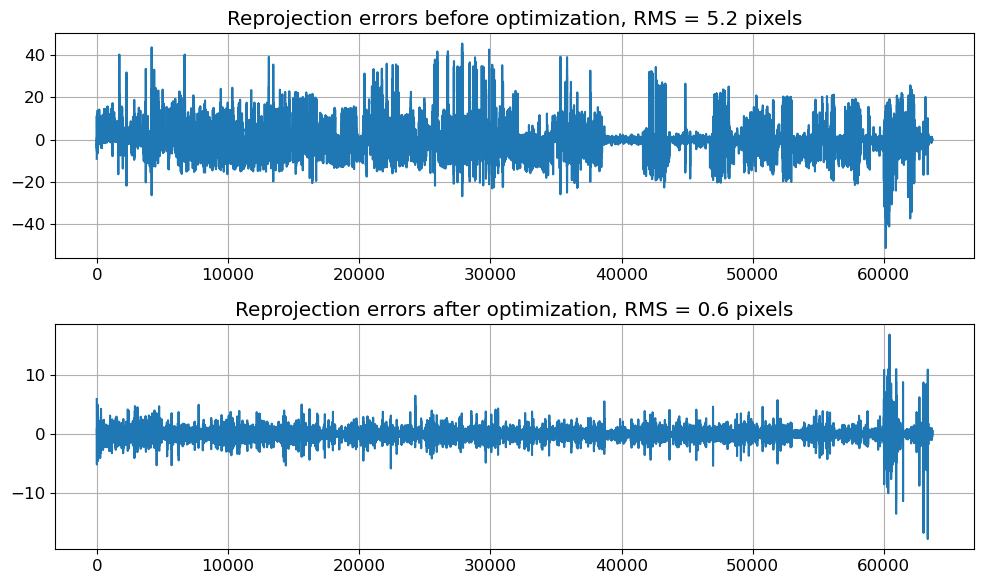

In [20]:
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.plot(fun0)
plt.title("Reprojection errors before optimization, RMS = {:.1f} pixels".format(np.mean(fun0**2) ** 0.5))

plt.subplot(212)
plt.plot(res.fun)
plt.title("Reprojection errors after optimization, RMS = {:.1f} pixels".format(np.mean(res.fun**2) ** 0.5))

plt.tight_layout()

We see significant improvements of the reprojection errors distribution and their RMS which indicates a successful optimization.

The remaining spikes can be explained by some sort of inconsistency in the input data or a compromised convergence of the algorithm. The convergence issues might be caused by finite difference approximation of the Jacobian.

Suggested excersises for the reader:

1. Implement analytical Jacobian computation and see if it improves the final cost function and removes the spikes.
2. Try to reduce the final cost function by adjusting the algorithm's parameters.
3. Visualize 3D point clouds before and after optimization